# Earthquake Prediction

In [1]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
from sklearn import preprocessing, model_selection, linear_model
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, recall_score

In [2]:
filepath = './data/earthquakes.csv'

In [3]:
df = pd.read_csv(filepath)
df = df.set_index('time')
df.index = pd.to_datetime(df.index)
df = df[::-1]
df = df.ffill(axis=0)
df.head()

,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
time,,,,,,,,,,,,,,,,,,,,,
2020-07-12 10:31:53.318000+00:00,67.791600,-158.636400,15.00,1.10,ml,NaN,NaN,NaN,0.42,ak,...,2020-08-04T02:49:26.410Z,"85 km NNW of Ambler, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
2020-07-12 10:38:04.580000+00:00,33.177833,-116.127833,11.36,0.72,ml,35.0,60.0,0.040210,0.19,ci,...,2020-07-13T22:21:26.937Z,"4km N of Ocotillo Wells, CA",earthquake,0.24,0.34,0.158,12.0,reviewed,ci,ci
2020-07-12 10:38:50.280000+00:00,38.816334,-122.813500,3.17,0.91,md,22.0,46.0,0.007542,0.02,nc,...,2020-07-12T11:51:04.930Z,"7km NW of The Geysers, CA",earthquake,0.26,0.50,0.130,3.0,automatic,nc,nc
2020-07-12 10:40:29.962000+00:00,63.047100,-150.433700,107.20,1.10,ml,22.0,46.0,0.007542,0.21,ak,...,2020-08-04T02:49:33.285Z,"63 km NNE of Petersville, Alaska",earthquake,0.26,0.50,0.130,3.0,reviewed,ak,ak
2020-07-12 10:50:55.660000+00:00,36.073167,-117.642167,4.75,0.88,ml,13.0,85.0,0.110600,0.14,ci,...,2020-07-12T16:37:38.032Z,"28km E of Coso Junction, CA",earthquake,0.27,2.64,0.189,9.0,reviewed,ci,ci


In [4]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,35245.000000,35245.000000,35245.000000,35245.000000,35244.000000,35244.000000,35244.000000,35245.000000,35244.000000,35245.000000,35244.000000,35244.000000
mean,37.167296,-108.587333,21.477970,1.662998,22.923874,116.367907,0.802746,0.275335,1.841804,4.240555,0.256224,16.690160
std,19.093452,67.751199,54.360028,1.311455,20.870127,60.163061,2.755236,0.272876,3.228899,389.379273,0.471036,32.924174
min,-65.352200,-179.996400,-3.730000,-1.430000,0.000000,11.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
25%,33.420500,-149.703200,3.600000,0.800000,10.000000,71.000000,0.025000,0.100000,0.270000,0.470000,0.105000,5.000000
50%,38.151200,-118.777667,8.000000,1.340000,17.000000,102.000000,0.059910,0.160000,0.470000,0.800000,0.161000,9.000000
75%,47.511900,-113.778167,14.560000,2.110000,28.000000,150.000000,0.165500,0.400000,1.020000,1.780000,0.236515,18.000000
max,87.349200,180.000000,647.998000,7.800000,444.000000,355.000000,43.236000,2.460000,26.400000,73091.100000,5.520000,760.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35245 entries, 2020-07-12 10:31:53.318000+00:00 to 2022-10-06 13:10:10.910000+00:00
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         35245 non-null  float64
 1   longitude        35245 non-null  float64
 2   depth            35245 non-null  float64
 3   mag              35245 non-null  float64
 4   magType          35245 non-null  object 
 5   nst              35244 non-null  float64
 6   gap              35244 non-null  float64
 7   dmin             35244 non-null  float64
 8   rms              35245 non-null  float64
 9   net              35245 non-null  object 
 10  id               35245 non-null  object 
 11  updated          35245 non-null  object 
 12  place            35245 non-null  object 
 13  type             35245 non-null  object 
 14  horizontalError  35244 non-null  float64
 15  depthError       35245 non-null  float64
 1

In [6]:
df.isnull().sum()

latitude           0
longitude          0
depth              0
mag                0
magType            0
nst                1
gap                1
dmin               1
rms                0
net                0
id                 0
updated            0
place              0
type               0
horizontalError    1
depthError         0
magError           1
magNst             1
status             0
locationSource     0
magSource          0
dtype: int64

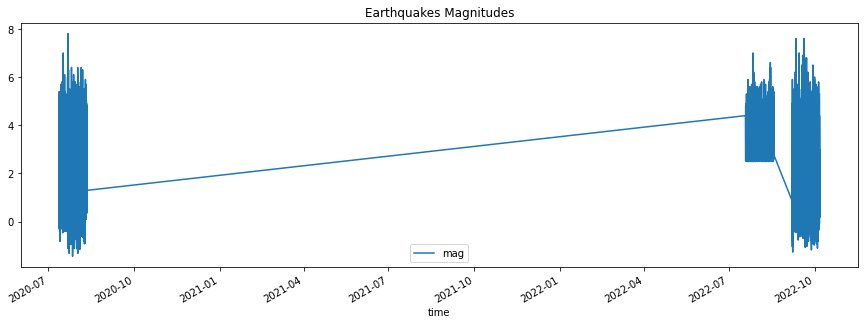

In [7]:
df.plot(figsize=(15, 5), title='Earthquakes Magnitudes', y='mag')
plt.show()

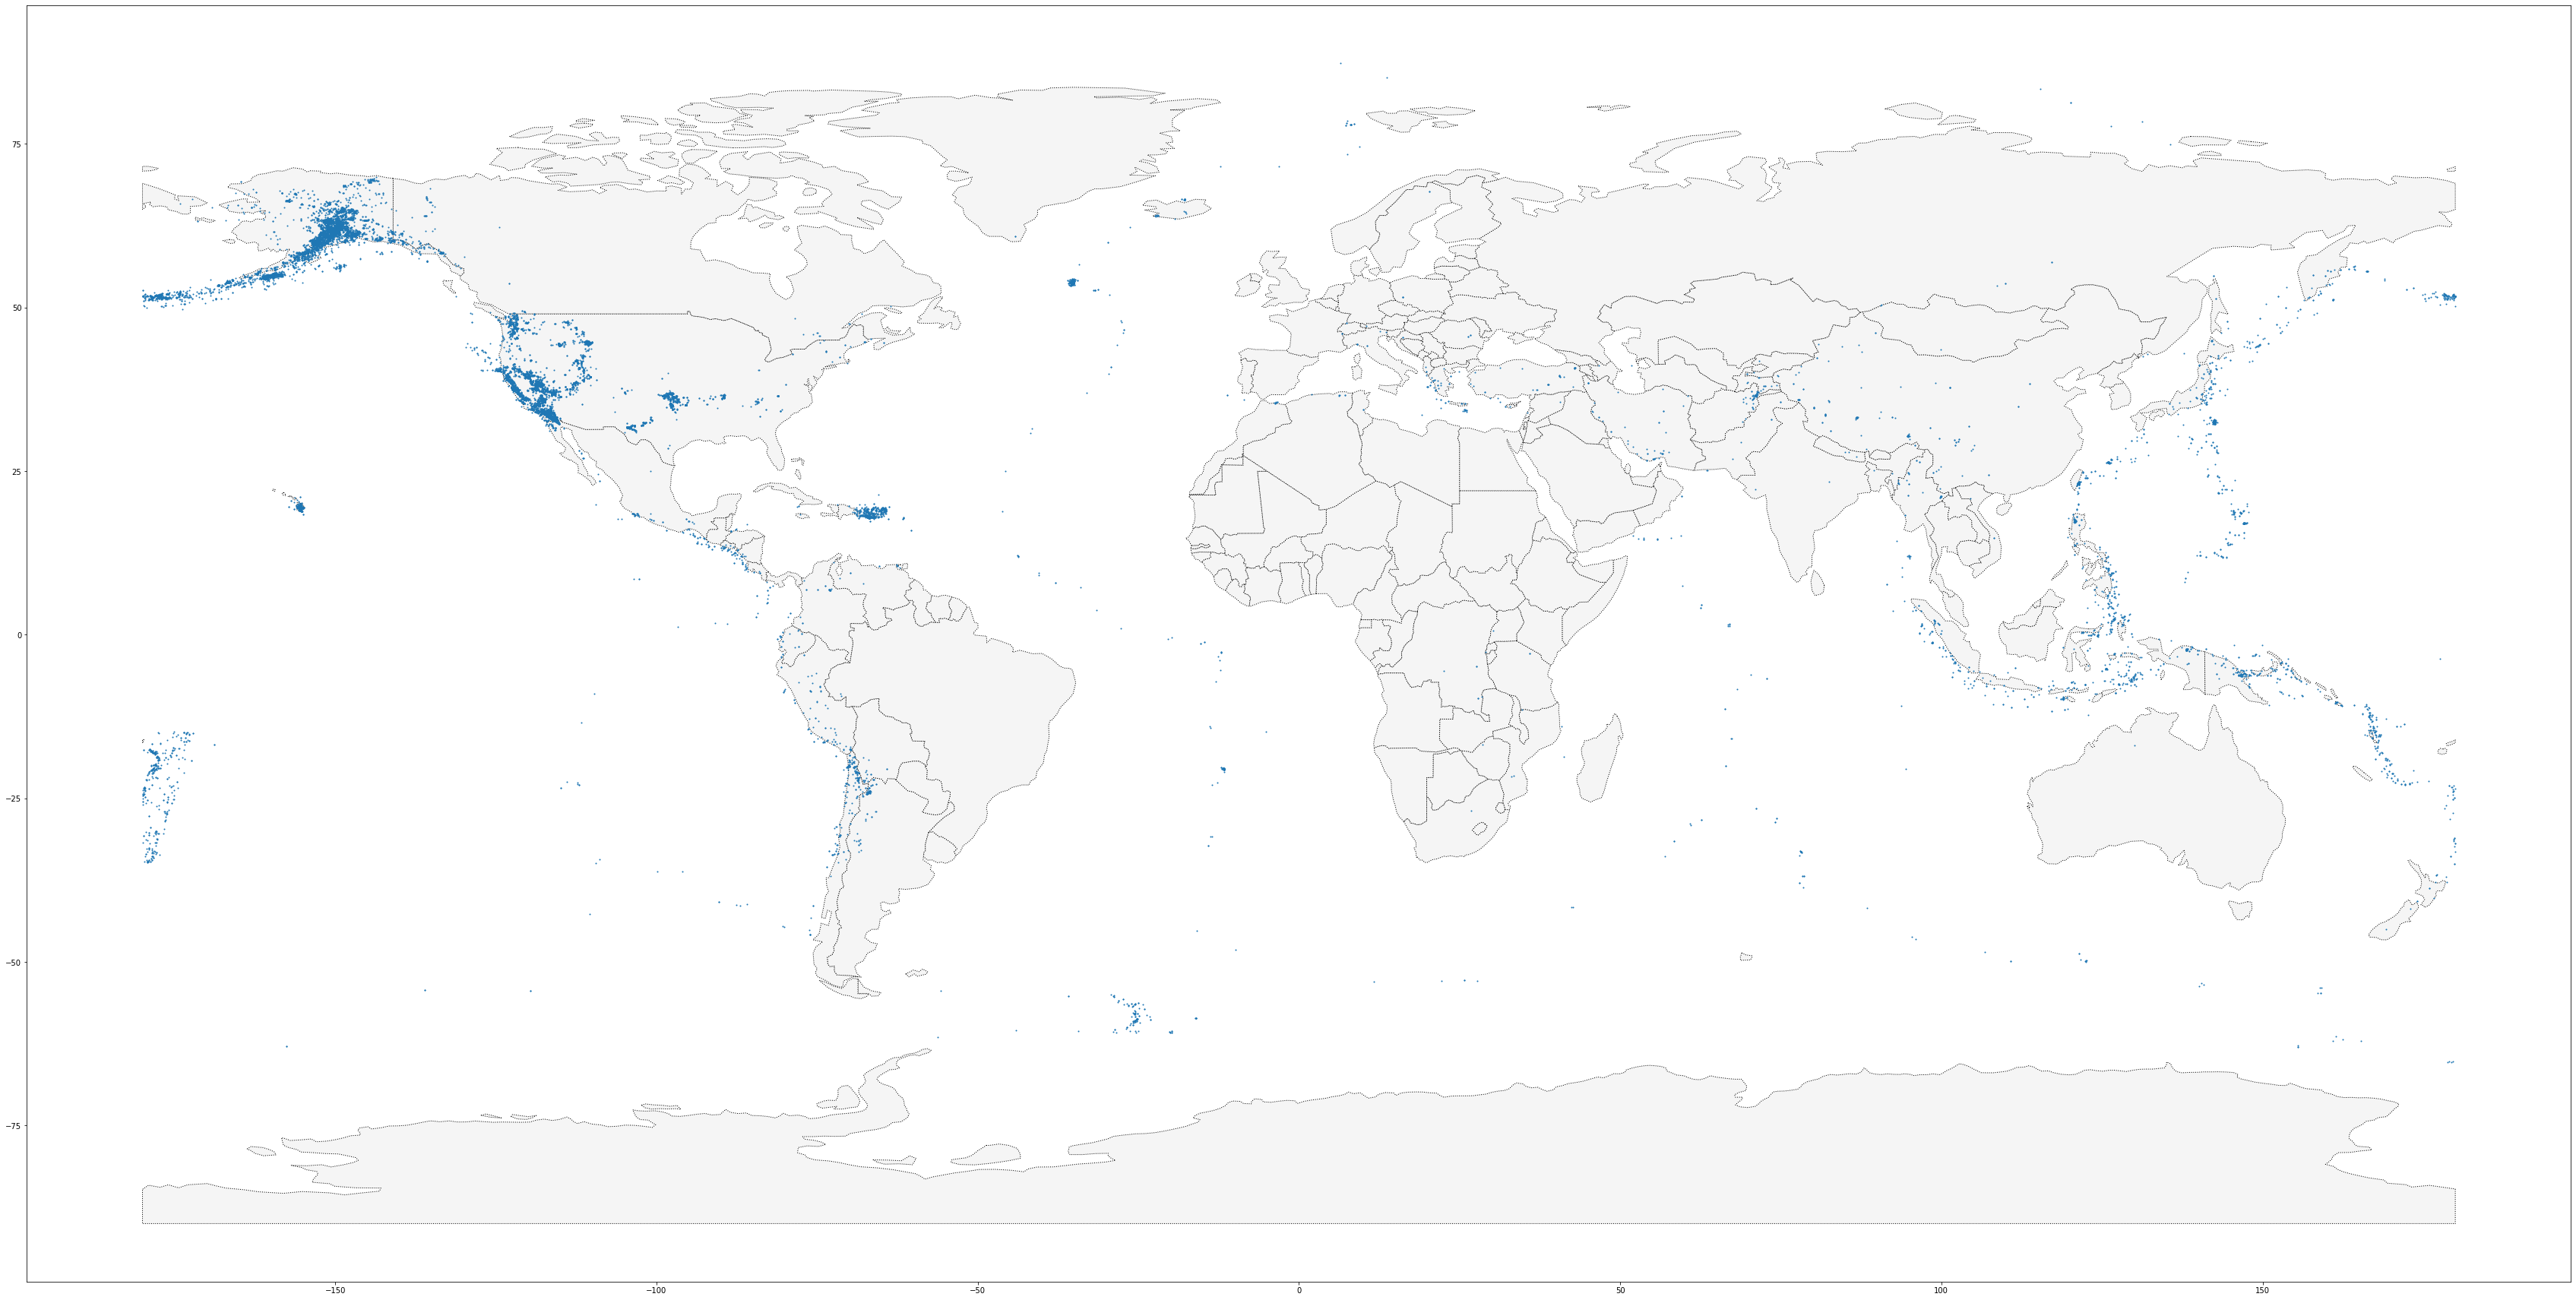

In [8]:
earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
earthquakes.crs = 'EPSG:4326'

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

ax = world.plot(figsize=(60, 60), color='whitesmoke', linestyle=':', edgecolor='black')
earthquakes.to_crs(epsg=4326).plot(markersize=1, ax=ax)
plt.show()

In [9]:
print(f'Min magnitude: {df.mag.min()}')
print(f'Max magnitude: {df.mag.max()}')

Min magnitude: -1.43
Max magnitude: 7.8


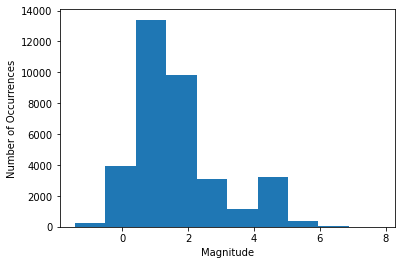

In [10]:
plt.hist(df.mag)
plt.xlabel('Magnitude')
plt.ylabel('Number of Occurrences')
plt.show()

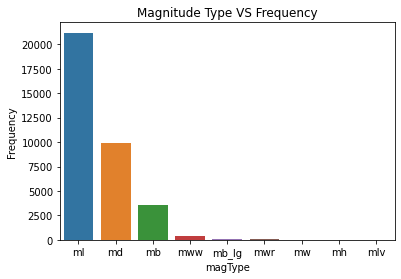

local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)


In [11]:
sns.countplot(data=df, x='magType')
plt.ylabel('Frequency')
plt.title('Magnitude Type VS Frequency')
plt.show()

print('local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)')

In [12]:
df.loc[df.mag >= 8, 'Class'] = 'Disastrous'
df.loc[(df.mag >= 7) & (df.mag < 7.9), 'Class'] = 'Major'
df.loc[(df.mag >= 6) & (df.mag < 6.9), 'Class'] = 'Strong'
df.loc[(df.mag >= 5.5) & (df.mag < 5.9), 'Class'] = 'Moderate'

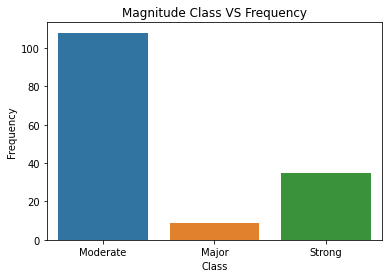

In [13]:
sns.countplot(data=df, x='Class')
plt.ylabel('Frequency')
plt.title('Magnitude Class VS Frequency')
plt.show()

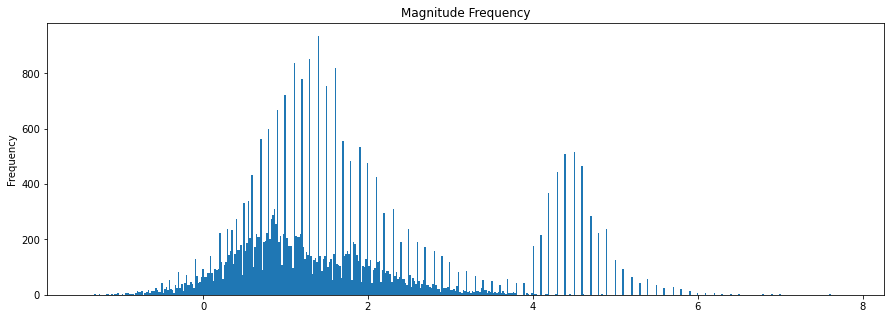

In [14]:
df.mag.plot(kind='hist', bins=500, figsize=(15, 5))
plt.title('Magnitude Frequency')
plt.show()

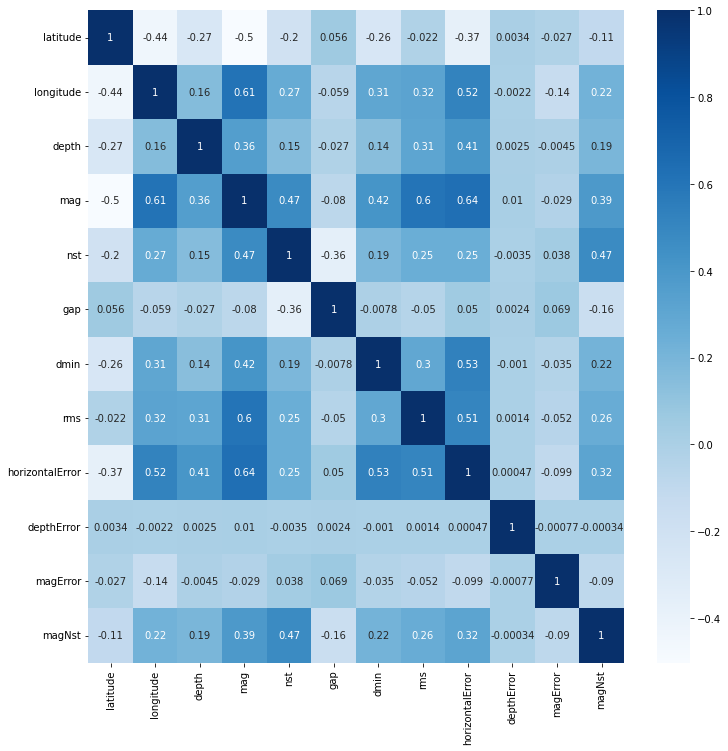

In [15]:
corr_matrix = df.corr() 
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()

In [16]:
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df = df.drop(to_drop, axis=1)

In [17]:
for column in df.columns:
    if df[column].isna().mean() > 0.3:
        df = df.drop(column, axis=1) 

In [18]:
df.place = df.place.str.split(', ', expand=True)[1]
df.place.head() 

time
2020-07-12 10:31:53.318000+00:00    Alaska
2020-07-12 10:38:04.580000+00:00        CA
2020-07-12 10:38:50.280000+00:00        CA
2020-07-12 10:40:29.962000+00:00    Alaska
2020-07-12 10:50:55.660000+00:00        CA
Name: place, dtype: object

In [19]:
print(f'Total locations: {len(set(df.place))}')

Total locations: 135


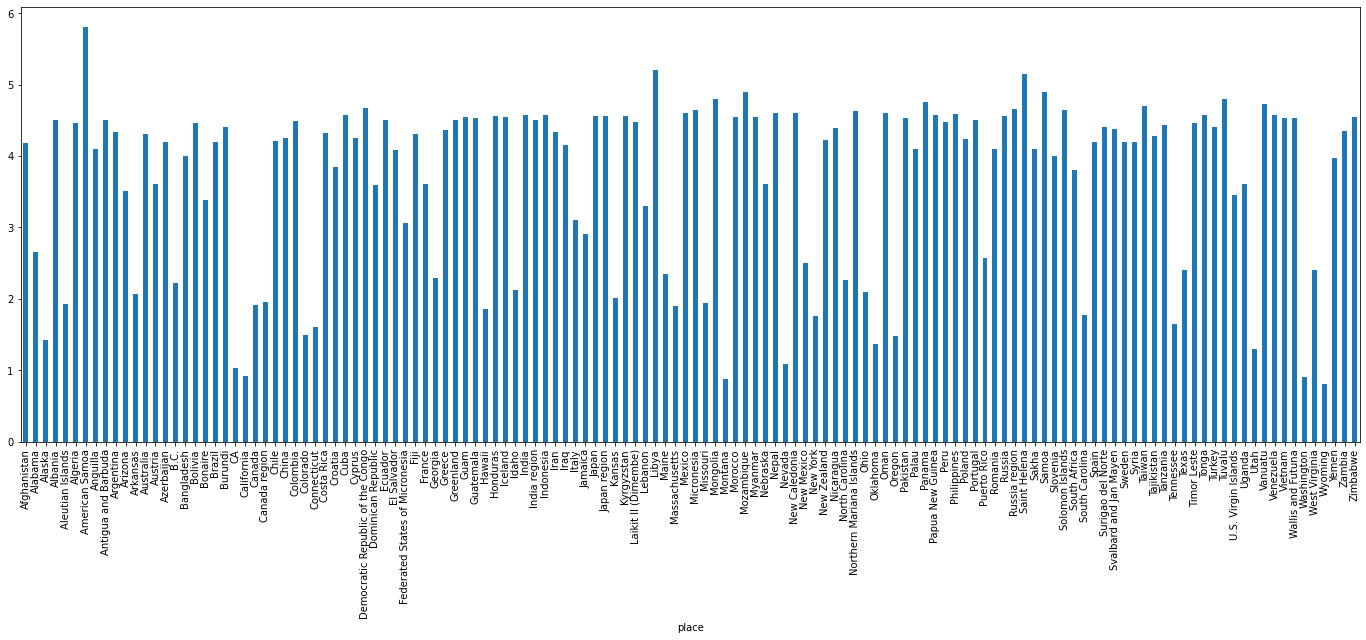

In [20]:
df.groupby(['place'])['mag'].mean().plot(kind='bar',figsize=(24, 8))
plt.show()

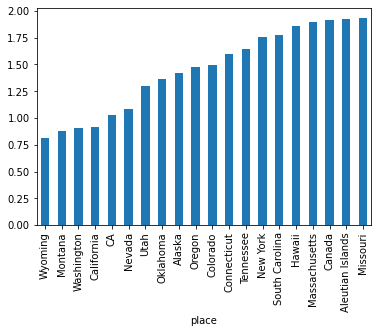

In [21]:
df.groupby(['place'])['mag'].mean().nsmallest(20).plot(kind='bar')
plt.show()

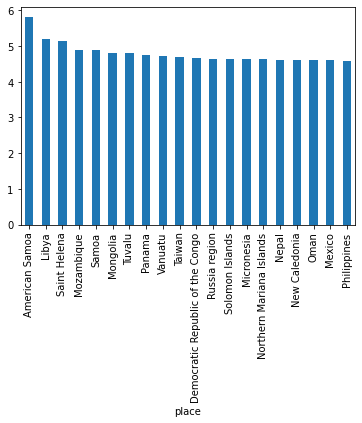

In [22]:
df.groupby(['place'])['mag'].mean().nlargest(20).plot(kind='bar')
plt.show()

In [24]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Creates time series features based on time series index."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['quarter'] = df.index.quarter
    df['season'] = df.month % 12 // 3 + 1
    return df

def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5eq_lag'] = df.mag.shift(5)
    df['mag_10eq_lag'] = df.mag.shift(10)
    df['mag_15eq_lag'] = df.mag.shift(15)

    df['depth_5eq_lag'] = df.depth.shift(5)
    df['depth_10eq_lag'] = df.depth.shift(10)
    df['depth_15eq_lag'] = df.depth.shift(15)
    return df

def add_rolling_windows(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5eq_avg'] = df.mag.rolling(window=5, center=False).mean()
    df['mag_10eq_avg'] = df.mag.rolling(window=10, center=False).mean()
    df['mag_15eq_avg'] = df.mag.rolling(window=15, center=False).mean()
    df['mag_5eq_min'] = df.mag.rolling(window=5, center=False).min()
    df['mag_10eq_min'] = df.mag.rolling(window=10, center=False).min()
    df['mag_15eq_min'] = df.mag.rolling(window=15, center=False).min()
    df['mag_5eq_max'] = df.mag.rolling(window=5, center=False).max()
    df['mag_10eq_max'] = df.mag.rolling(window=10, center=False).max()
    df['mag_15eq_max'] = df.mag.rolling(window=15, center=False).max()
    df['mag_5eq_std'] = df.mag.rolling(window=5, center=False).std()
    df['mag_10eq_std'] = df.mag.rolling(window=10, center=False).std()
    df['mag_15eq_std'] = df.mag.rolling(window=15, center=False).std()

    df['depth_5eq_avg'] = df.depth.rolling(window=5, center=False).mean()
    df['depth_10eq_avg'] = df.depth.rolling(window=10, center=False).mean()
    df['depth_15eq_avg'] = df.depth.rolling(window=15, center=False).mean()
    df['depth_5eq_min'] = df.depth.rolling(window=5, center=False).min()
    df['depth_10eq_min'] = df.depth.rolling(window=10, center=False).min()
    df['depth_15eq_min'] = df.depth.rolling(window=15, center=False).min()
    df['depth_5eq_max'] = df.depth.rolling(window=5, center=False).max()
    df['depth_10eq_max'] = df.depth.rolling(window=10, center=False).max()
    df['depth_15eq_max'] = df.depth.rolling(window=15, center=False).max()
    df['depth_5eq_std'] = df.depth.rolling(window=5, center=False).std()
    df['depth_10eq_std'] = df.depth.rolling(window=10, center=False).std()
    df['depth_15eq_std'] = df.depth.rolling(window=15, center=False).std()
    return df

data = []
for place in df.place.unique():
    temp = df.loc[df.place == place]
    temp = create_features(temp)
    temp = add_lags(temp)
    temp = add_rolling_windows(temp)

    data.append(temp)

df = pd.concat(data)

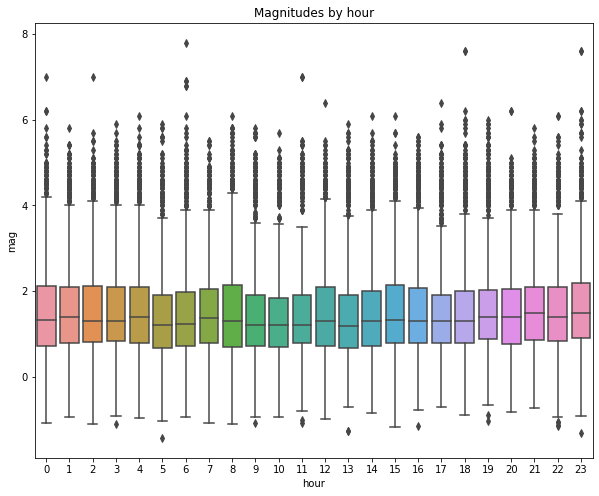

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='mag')
ax.set_title('Magnitudes by hour')
plt.show()

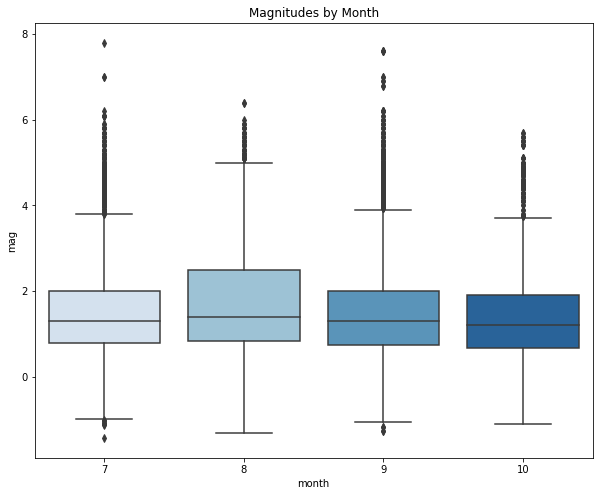

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='mag', palette='Blues')
ax.set_title('Magnitudes by Month')
plt.show()

In [27]:
features = [
    'dayofyear',
    'hour',
    'dayofweek',
    'month',
    'season',
    'year',
    'mag_5eq_lag',
    'mag_10eq_lag',
    'mag_15eq_lag',
    'mag_5eq_avg',
    'mag_10eq_avg',
    'mag_15eq_avg',
    'mag_5eq_min',
    'mag_10eq_min',
    'mag_15eq_min',
    'mag_5eq_max',
    'mag_10eq_max',
    'mag_15eq_max',
    'mag_5eq_std',
    'mag_10eq_std',
    'mag_15eq_std',
    'depth_5eq_lag',
    'depth_10eq_lag',
    'depth_15eq_lag',
    'depth_5eq_avg',
    'depth_10eq_avg',
    'depth_15eq_avg',
    'depth_5eq_min',
    'depth_10eq_min',
    'depth_15eq_min',
    'depth_5eq_max',
    'depth_10eq_max',
    'depth_15eq_max',
    'depth_5eq_std',
    'depth_10eq_std',
    'depth_15eq_std',
    'latitude',
    'longitude',
]
cat_features = ['place']
target = 'mag'

In [28]:
date = '2022-09-25 00:00:00.000000+00:00'

df_train = df.loc[df.index < date]
df_train = df_train[features + cat_features + [target]]

df_test = df.loc[df.index >= date]
df_test = df_test[features + cat_features + [target]]

In [29]:
print(f'Test size: {len(df_test) / (len(df_test) + len(df_train))}')

Test size: 0.20883582813162838


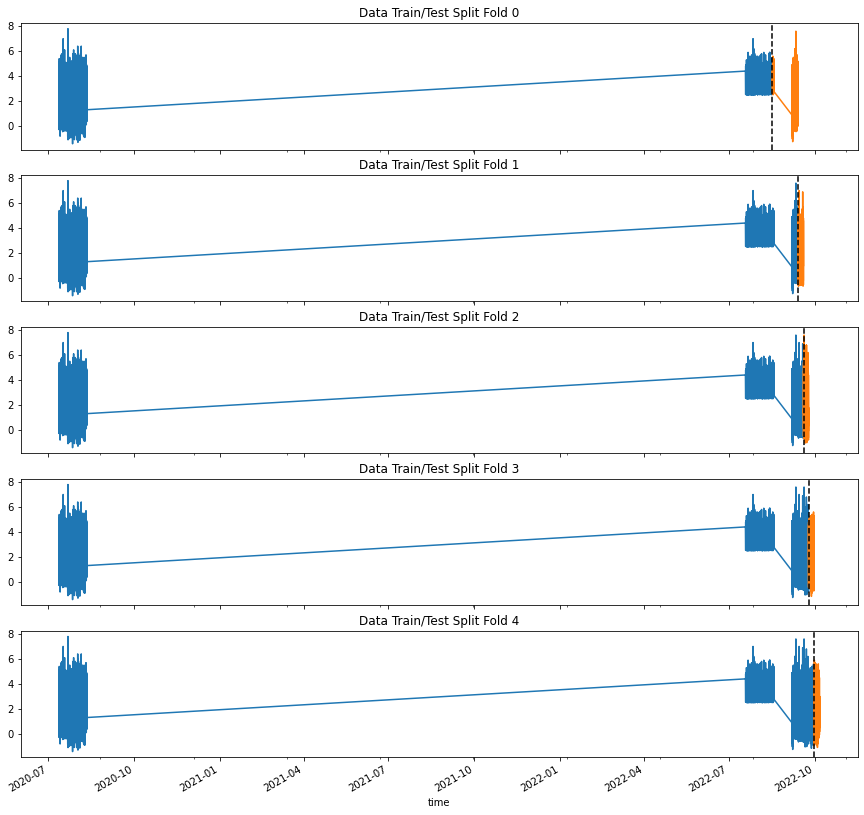

In [30]:
tss = model_selection.TimeSeriesSplit(n_splits=5, test_size=3600, gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train.mag.plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test.mag.plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [31]:
fold = 0
predictions = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    x_train = train[features + cat_features]
    y_train = train[target]

    x_test = test[features + cat_features]
    y_test = test[target]

    model = cb.CatBoostRegressor(
        depth=7, 
        learning_rate=0.01, 
        iterations=1000, 
        early_stopping_rounds=50,
        cat_features=cat_features,
    )
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)

    y_pred = model.predict(x_test)
    predictions.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

0:	learn: 1.2206065	test: 1.2206065	test1: 1.2962971	best: 1.2962971 (0)	total: 84.9ms	remaining: 1m 24s
100:	learn: 0.7312570	test: 0.7312570	test1: 0.7866561	best: 0.7866561 (100)	total: 1.61s	remaining: 14.3s
200:	learn: 0.6033293	test: 0.6033293	test1: 0.6776469	best: 0.6776469 (200)	total: 3.1s	remaining: 12.3s
300:	learn: 0.5611180	test: 0.5611180	test1: 0.6654076	best: 0.6626398 (271)	total: 4.47s	remaining: 10.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6626397908
bestIteration = 271

Shrink model to first 272 iterations.
0:	learn: 1.2372606	test: 1.2372606	test1: 1.2497859	best: 1.2497859 (0)	total: 18ms	remaining: 18s
100:	learn: 0.7325340	test: 0.7325340	test1: 0.7763540	best: 0.7763540 (100)	total: 1.61s	remaining: 14.3s
200:	learn: 0.6045979	test: 0.6045979	test1: 0.6513807	best: 0.6513807 (200)	total: 3.18s	remaining: 12.6s
300:	learn: 0.5630139	test: 0.5630139	test1: 0.6099757	best: 0.6099757 (300)	total: 4.69s	remaining: 10.9s
400:	learn: 0.54

In [32]:
print(f'Score across folds {np.mean(scores)}')
print(f'Fold scores:{scores}')

Score across folds 0.5535240334353592
Fold scores:[0.6626397898950249, 0.5465668759331545, 0.5159360823748932, 0.5023975135342068, 0.5400799054395166]


In [33]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    df_train[features + cat_features],
    df_train[target], 
    test_size=0.2, 
    random_state=42,
)

In [34]:
grid = {
    'depth': [5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [1500],
}

model = cb.CatBoostRegressor(early_stopping_rounds=50, cat_features=cat_features)
grid_search_result = model.grid_search(grid, x_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0310187	test: 1.9635570	best: 1.9635570 (0)	total: 17.4ms	remaining: 26s
1:	learn: 2.0134523	test: 1.9466315	best: 1.9466315 (1)	total: 64.4ms	remaining: 48.2s
2:	learn: 1.9960780	test: 1.9299198	best: 1.9299198 (2)	total: 81.5ms	remaining: 40.7s
3:	learn: 1.9788375	test: 1.9133821	best: 1.9133821 (3)	total: 106ms	remaining: 39.6s
4:	learn: 1.9618241	test: 1.8972467	best: 1.8972467 (4)	total: 124ms	remaining: 37.2s
5:	learn: 1.9451871	test: 1.8811862	best: 1.8811862 (5)	total: 139ms	remaining: 34.6s
6:	learn: 1.9289722	test: 1.8655440	best: 1.8655440 (6)	total: 152ms	remaining: 32.5s
7:	learn: 1.9123620	test: 1.8495102	best: 1.8495102 (7)	total: 168ms	remaining: 31.3s
8:	learn: 1.8961541	test: 1.8339664	best: 1.8339664 (8)	total: 181ms	remaining: 30.1s
9:	learn: 1.8797664	test: 1.8183267	best: 1.8183267 (9)	total: 194ms	remaining: 29s
10:	learn: 1.8635634	test: 1.8027683	best: 1.8027683 (10)	total: 207ms	remaining: 28s
11:	learn: 1.8477215	test: 1.7876266	best: 1.7876266 (1

In [35]:
grid_search_result['params']

{'depth': 7, 'iterations': 1500, 'learning_rate': 0.1}

In [36]:
prediction = model.predict(x_test)
print(f'Accuracy of Model: {model.score(x_test, y_test)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, prediction))}')

Accuracy of Model: 0.8635757086444973
Mean Absolute Error: 0.3378456523457315
Root Mean Squared Error: 0.46148333144228654


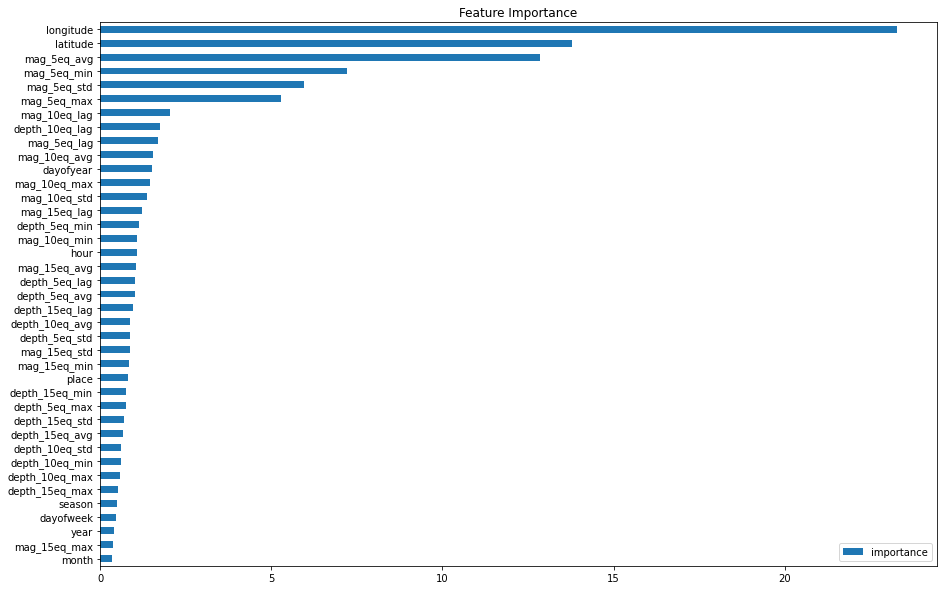

In [37]:
fi = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(15, 10))
plt.show()

Accuracy of Model: 0.8267893492941887
Mean Absolute Error: 0.35864545835791267
Root Mean Squared Error: 0.49415574895112185


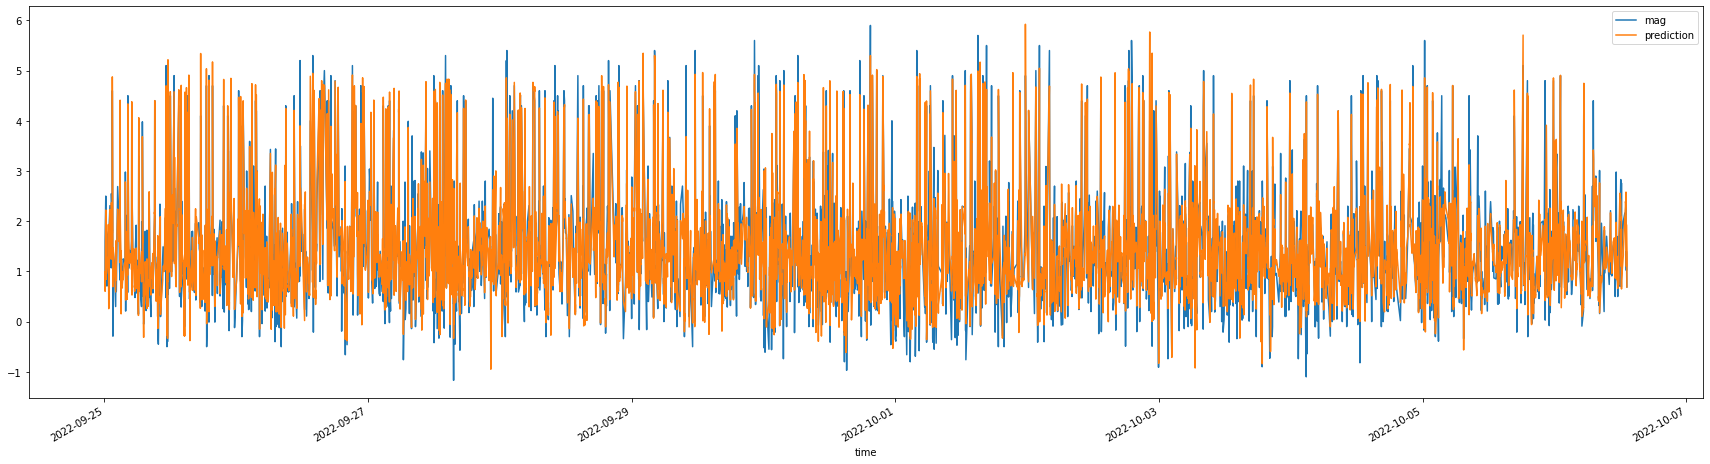

In [38]:
prediction = model.predict(df_test[features + cat_features])
print(f'Accuracy of Model: {model.score(df_test[features + cat_features], df_test[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(df_test[target], prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(df_test[target], prediction))}')

df_plot = pd.DataFrame({'mag': df_test[target], 'prediction': prediction}, index=df_test.index)
df_plot = df_plot[::-1]
df_plot.plot(figsize=(30, 8))
plt.show()

In [39]:
live_data = pd.read_csv('https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&eventtype=earthquake')
live_data = live_data.set_index('time')
live_data.index = pd.to_datetime(live_data.index)
live_data.place = live_data.place.str.split(', ', expand=True)[1]
live_data = live_data[::-1]
live_data = live_data.ffill()

In [40]:
data = []
for place in live_data.place.unique():
    temp = live_data.loc[live_data.place == place]
    temp = create_features(temp)
    temp = add_lags(temp)
    temp = add_rolling_windows(temp)

    data.append(temp)

live_data = pd.concat(data)

Accuracy of Model: 0.7670319059661792
Mean Absolute Error: 0.4425656729697104
Root Mean Squared Error: 0.597361468652733


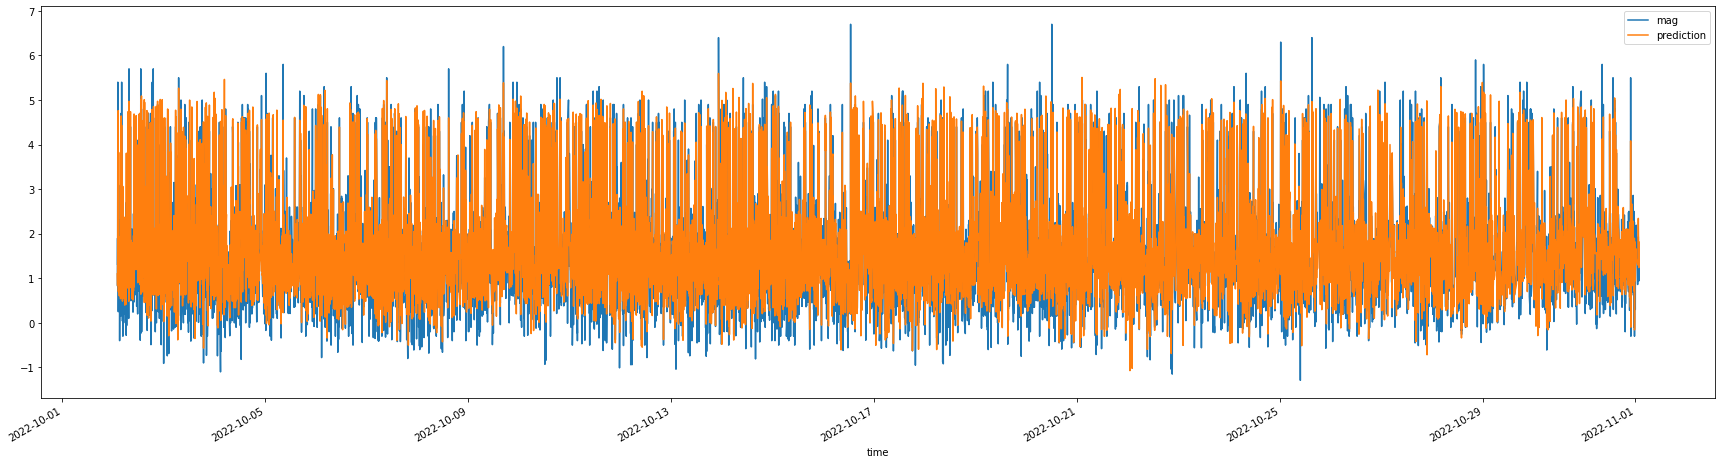

In [41]:
live_prediction = model.predict(live_data[features + cat_features])
print(f'Accuracy of Model: {model.score(live_data[features + cat_features], live_data[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(live_data[target], live_prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(live_data[target], live_prediction))}')

df_live = pd.DataFrame({'mag': live_data[target], 'prediction': live_prediction}, index=live_data.index)
df_live = df_live[::-1]
df_live.plot(figsize=(30, 8))
plt.show()

In [43]:
# model.save_model('../app/server/app/ml/model')